## End-to-End Vehicle Dataset Machine Learning Project

### Goal
- The goal of this project is to build a machine learning model that predicts a car’s **selling price** based on its attributes.
- The solution is intended for **car dealers** who want to estimate vehicle prices **without relying on expert appraisal**.
- Current common approaches include:
  - Asking for expert valuation
  - Manually analyzing the market
  - Using rough average prices

### Problem Framing
- This problem is framed as a **supervised learning** task because the target variable (selling price) is known.
- It is an **offline (batch) learning** problem since the dataset is already available and does not update continuously.
- The model is trained once on historical data rather than learning in real time.

### Evaluation Metric
- Model performance is evaluated using **RMSE (Root Mean Squared Error)**, which measures how far the predicted prices deviate from the actual selling prices.
- RMSE is chosen because it penalizes large errors and is well-suited for regression problems.
- Prediction confidence is interpreted in terms of how close predictions are to real values.

### Business Objective
- The minimum acceptable performance for the model is to **predict vehicle prices with at least 95% confidence**, meeting the business requirements for pricing reliability.



#### Loading & Inspecting Data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
from pathlib import Path

vehicles = pd.read_csv(Path("datasets/vehicle/Car details v3.csv"))

In [48]:
vehicles.shape

(8128, 13)

In [49]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [50]:
from sklearn.model_selection import train_test_split
label = vehicles['selling_price']
features = vehicles.drop(columns = ["selling_price"], axis=1)
X_train, X_test, Y_train, Y_test =  train_test_split(features, label, test_size=0.2, random_state=42)



## Exploratory Data Analysis

**Goal**: study attributes and its characteristics such as name, type(categorical int, text, etc.) % of missing values, noisiness, possibly useful for the task ?

## Name
-	Car brand + model.
- High cardinality categorical feature.
	- Not ideal directly (too many unique values).
	- ️ Maybe extract brand later, otherwise likely drop.


In [51]:
vehicles["name"]

0             Maruti Swift Dzire VDI
1       Skoda Rapid 1.5 TDI Ambition
2           Honda City 2017-2020 EXi
3          Hyundai i20 Sportz Diesel
4             Maruti Swift VXI BSIII
                    ...             
8123               Hyundai i20 Magna
8124           Hyundai Verna CRDi SX
8125          Maruti Swift Dzire ZDi
8126                 Tata Indigo CR4
8127                 Tata Indigo CR4
Name: name, Length: 8128, dtype: object

#### year

- Manufacturing year of the car.
- Numeric and meaningful.
- Very useful (proxy for car_age)
- Might later convert it to car_age = current_year - year.

In [52]:
vehicles["year"].value_counts()

year
2017    1018
2016     859
2018     807
2015     776
2013     670
2012     651
2014     621
2011     592
2019     583
2010     394
2009     246
2008     214
2007     183
2006     124
2005      97
2020      74
2004      62
2003      49
2002      27
2000      22
1999      18
1997      11
2001      10
1998      10
1996       3
1994       3
1995       2
1983       1
1991       1
Name: count, dtype: int64

selling_price (TARGET)

- Price of the car, Numeric, Target variable for regression, likely right-skewed.

In [53]:
vehicles["selling_price"].head()

0    450000
1    370000
2    158000
3    225000
4    130000
Name: selling_price, dtype: int64

km_driven

- Total kilometers driven. Numeric.

In [54]:
vehicles["km_driven"]

0       145500
1       120000
2       140000
3       127000
4       120000
         ...  
8123    110000
8124    119000
8125    120000
8126     25000
8127     25000
Name: km_driven, Length: 8128, dtype: int64

fuel

- Fuel Type (Petrol, Diesel, CNG, etc.
- Categorical
- Suitable for OneHotEncoding

In [55]:
vehicles["fuel"].value_counts()

fuel
Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: count, dtype: int64

seller_type

- Type of seller (Dealer, Individual, Trustmark)
- Categorical
- Low cardinality, good for encoding.


In [56]:
vehicles["seller_type"].value_counts()

seller_type
Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: count, dtype: int64

transmission

- Manual / Automatic
- Categorical
- Clean, low cardinality suitable for OneHotEncoding

In [57]:
vehicles["transmission"].value_counts()

transmission
Manual       7078
Automatic    1050
Name: count, dtype: int64

Ownership history (First Owner, Second Owner etc.)

- Categorical but ordinal in nature.
- Could be encoded ordinally or one-hot.
- Needs careful handling later.

In [58]:
vehicles["owner"].value_counts()

owner
First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: count, dtype: int64

#### Fuel consumption of a Car, we have to extract values somehow in the feature engineering section.

KMPL (Kilometers Per Liter): Used for petrol/diesel cars. Example: 20 kmpl means the car travels 20 km on 1 liter of fuel.
KM/KG (Kilometers Per Kilogram): Used for CNG vehicles. Example: 25 km/kg means the car travels 25 km on 1 kg of CNG.

- Stored as object
- Needs unit removal and numeric extraction
- Missing values are exists.

In [59]:
vehicles["mileage"]

0        23.4 kmpl
1       21.14 kmpl
2        17.7 kmpl
3        23.0 kmpl
4        16.1 kmpl
           ...    
8123     18.5 kmpl
8124     16.8 kmpl
8125     19.3 kmpl
8126    23.57 kmpl
8127    23.57 kmpl
Name: mileage, Length: 8128, dtype: object

engine

- Engine displacement (e.g. 1248 CC)
- Stored as object
- Needs parsing to numeric (CC)
- Strong predictor once cleaned.

In [60]:
vehicles["engine"].value_counts(ascending=True)

engine
1950 CC       1
1422 CC       1
3498 CC       1
1489 CC       1
2446 CC       1
           ... 
2179 CC     389
796 CC      444
998 CC      453
1197 CC     832
1248 CC    1017
Name: count, Length: 121, dtype: int64

max_power

- Engine power (e.g. "74bhp")
- Stored as object.
- needs numeric extraction
- Important performance-related feature


In [61]:
vehicles["max_power"].value_counts(ascending=True)

max_power
135.1 bhp       1
104 bhp         1
170.63 bhp      1
68.4 bhp        1
80.84 bhp       1
             ... 
46.3 bhp      162
67 bhp        165
88.5 bhp      204
81.80 bhp     220
74 bhp        377
Name: count, Length: 322, dtype: int64

torque

- Torque specification (complex text)
- Messy, mixed formats.
- Hard to clean reliably
- Might drop or extract partially.

In [62]:
vehicles["torque"]

0                  190Nm@ 2000rpm
1             250Nm@ 1500-2500rpm
2           12.7@ 2,700(kgm@ rpm)
3        22.4 kgm at 1750-2750rpm
4           11.5@ 4,500(kgm@ rpm)
                  ...            
8123             113.7Nm@ 4000rpm
8124    24@ 1,900-2,750(kgm@ rpm)
8125               190Nm@ 2000rpm
8126          140Nm@ 1800-3000rpm
8127          140Nm@ 1800-3000rpm
Name: torque, Length: 8128, dtype: object

seats

- Number of seats.
- Numeric (float due missing values)
- Simple, meaningful feature.
- Missing values can be imputed.

In [63]:
vehicles["seats"].value_counts()

seats
5.0     6254
7.0     1120
8.0      236
4.0      133
9.0       80
6.0       62
10.0      19
2.0        2
14.0       1
Name: count, dtype: int64

##### After inspecting each feature individually, we now have a clear understanding of the dataset’s structure, data types, and potential preprocessing challenges, allowing us to proceed to exploratory data analysis to study distributions, relationships, and patterns in the data.

#### Visual Exploratory Data Analysis

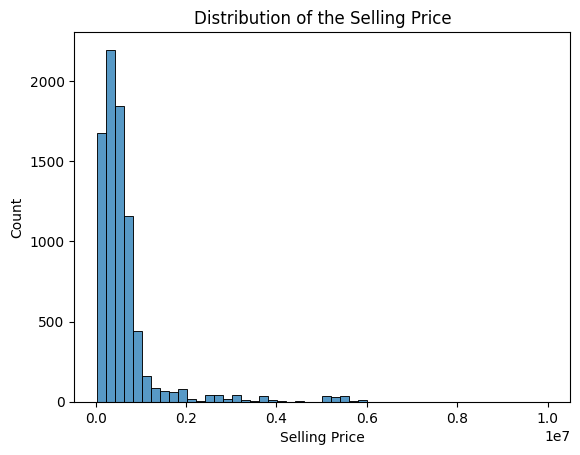

In [64]:
sns.histplot(data = vehicles , x = "selling_price", bins = 50)
plt.title("Distribution of the Selling Price")
plt.xlabel("Selling Price")
plt.show()

The selling price distribution is heavily right-skewed, with most vehicles concentrated in the lower price range and a long tail of high-pricerd outliers.

Let's look correlation between numeric features and selling_price since It's hard to plot all of the numerical features against we can do it promising features.

In [65]:
correlation_matrix = vehicles.corr(numeric_only = True)
correlation_matrix["selling_price"].sort_values(ascending = False)

selling_price    1.000000
year             0.414092
seats            0.041358
km_driven       -0.225534
Name: selling_price, dtype: float64

From the correlation matrix we can easily say there is almost 0 positive correlation between seats and selling price

But selling price has positive correlation between production year of the car. Newer cars tend to have higher price.

The exact opposite relationship between km_driven and selling price. They have a negative relationships as the km_driven goes up selling price tends to get low.


Let's plot those 2 promising relationship

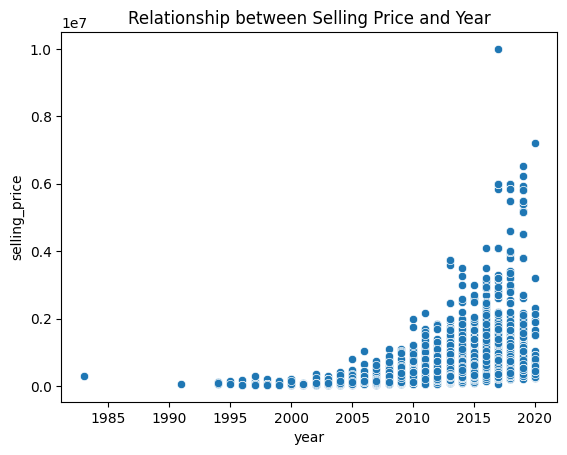

In [66]:
sns.scatterplot(data = vehicles, x = "year", y = "selling_price")
plt.title("Relationship between Selling Price and Year")
plt.show()

Plot confirms our conclusion. As the year of the manufacture for automatbiles apporaches the present day, their prices tend to increase.

Let's plot km_driven relationship with the selling prices.

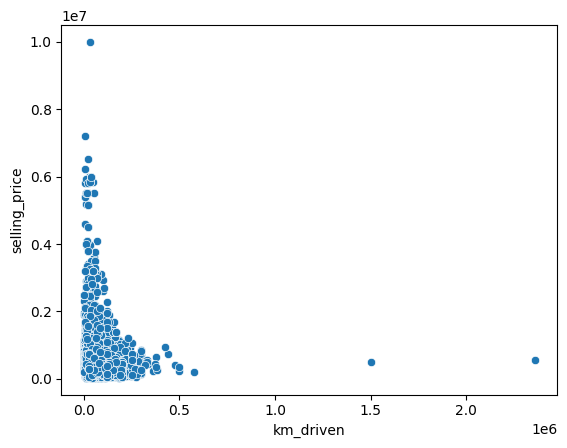

In [67]:
sns.scatterplot(data = vehicles, x = "km_driven", y = "selling_price")
plt.show()

This plot further confirms negative relationship between kilometers driven and selling price.

The visual analysis confirms meaningful relationships between key numerical features and the target variable, providing confidence that these attributes will be informative for predictive modeling.

### Let's compare the selling price with the Categorical features.


Firstly, Plot the fuel type effect on the selling price.

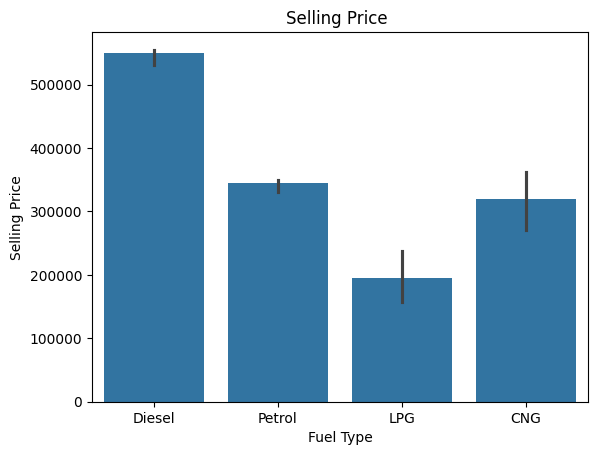

In [68]:
sns.barplot(data = vehicles, x = "fuel", y = "selling_price", estimator="median")
plt.xlabel("Fuel Type")
plt.ylabel("Selling Price")
plt.title("Selling Price ")
plt.show()

The plot shows that vehicles with diesel and petrol fuel types tend to have higher median selling prices compared to other fuel types, with diesel vehicles exhibiting the highest median price overall

Is owner effects selling_price? Lets plot it.

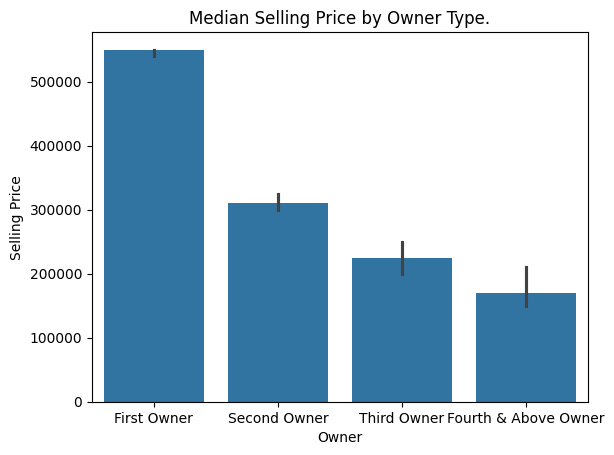

In [69]:
copy_vehicles = vehicles[vehicles["owner"] != "Test Drive Car"]
# we're dropping the test drive car's because they are so rare, and high likely  we do not have to predict 
# test drive car's selling price  in the real world, and let's look other types.
sns.barplot(data = copy_vehicles, x = "owner" , y = "selling_price" , estimator="median")
plt.title("Median Selling Price by Owner Type.")
plt.xlabel("Owner")
plt.ylabel("Selling Price")
plt.show()

For visualization clarity, the rare "Test Drive Car" category is excluded from this plot; this decision is exploratory and will be revisited during preprocessing.

The plot indicates a clear relationship between ownership history and selling price. Vehicles with fewer previous owners tend to have higher median prices, while prices decrease progressively as the number of owners increases. This suggests that ownership history is an important categorical feature for predicting vehicle prices.

Is seller_type's causes anything let's find out.

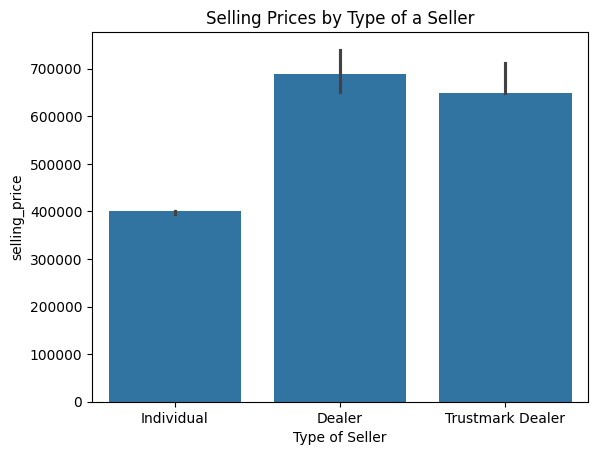

In [70]:
sns.barplot(data = vehicles, x = "seller_type",  y = "selling_price", estimator="median")
plt.title("Selling Prices by Type of a Seller")
plt.xlabel("Type of Seller")
plt.show()

The plot indicates that vehicles sold by dealers tend to have higher selling prices, followed by Trustmark Dealers, while cars sold by individual sellers generally have lower prices. This suggests that seller type is an important categorical feature influencing vehicle pricing.

And lets finally plot the Vehicle's tranmissions effect on the prices.


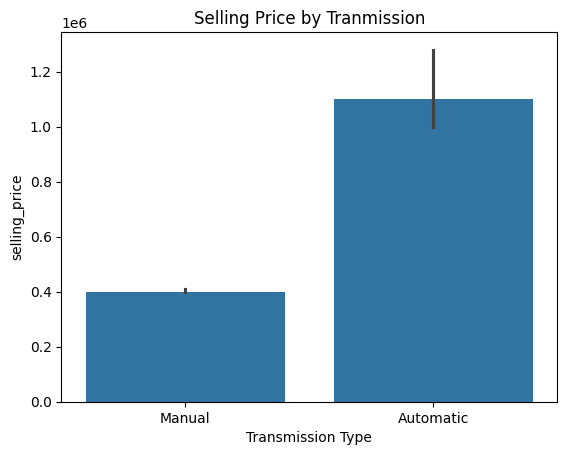

In [71]:
sns.barplot(vehicles, x = "transmission" , y = "selling_price", estimator="median")
plt.title("Selling Price by Tranmission")
plt.xlabel("Transmission Type")
plt.show()

The plot shows a clear difference in selling prices between transmission types. Vehicles with automatic transmission tend to have significantly higher median selling prices compared to manual transmission vehicles, indicating that transmission type is a strong categorical predictor of vehicle price.

The categorical feature analysis highlights meaningful differences in selling price across several categories, indicating that these variables are likely to be informative for the predictive model.

Overall, the exploratory data analysis reveals strong relationships between the selling price and several numerical and categorical features, providing confidence that the dataset contains meaningful signals for building a predictive machine learning model.


## Prepare the Data (Preprocessing & Pipelines)

In [72]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


It's working correctly and expected.

Let's extract the `engine_cc`  from the `engine` column, this will be good indicator for the predicting selling price.

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin


class EngineCCTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, drop_original = False):
        self.drop_original = drop_original


    def fit(self, X, y = None):
        return self
    
    @staticmethod
    def _to_engine_cc(val):
        # Keep missing values as NaN
        if pd.isna(val):
            return np.nan
        
        s = str(val).strip()
        if not s:
            return np.nan
        
        # Expected format like : "1248 CC"
        first_token = s.split()[0]

        #Convert token to float (safe).
        try:
            return float(first_token)
        except ValueError:
            return np.nan
        

    def transform(self, X):
        X = X.copy()

        if "engine" in X.columns:
            X["engine_cc"] = X["engine"].apply(self._to_engine_cc)

            if self.drop_original:
                X = X.drop(columns= ["engine"])
    
        return  X
    

engine_tf = EngineCCTransformer(drop_original=False)
tmp = engine_tf.fit_transform(X_train)
tmp[["engine", "engine_cc"]]
    

,engine,engine_cc
6518,1199 CC,1199.0
6144,1198 CC,1198.0
6381,1396 CC,1396.0
438,1248 CC,1248.0
5939,998 CC,998.0
...,...,...
5226,2179 CC,2179.0
5390,1248 CC,1248.0
860,1197 CC,1197.0
7603,1248 CC,1248.0


This one is works as we expected.

Let's build the transformer for the `max_power` -> `max_power_bhp`.

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class MaxPowerTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, drop_original = False):
        self.drop_original = drop_original


    def fit(self, X, y = None):
        return self
    
    @staticmethod
    def _extract_horsepower(val):

        if pd.isna(val): # if value is null
            return np.nan # return np nan value.
        
        s = str(val).strip()

        if not s:
            return np.nan
        
        # expected token 103.52 bhp.
        first_token = s.split()[0]
        
        try:
            return float(first_token)
        except ValueError:
            return np.nan
        

    
    def transform(self, X):
        X = X.copy()
        
        if "max_power" in X.columns:
            X["max_power_bhp"] = X["max_power"].apply(self._extract_horsepower)

        if self.drop_original:
            X = X.drop(columns = ["max_power"])
        
        return X
         
        

max_power_transformer = MaxPowerTransformer(drop_original=False)
horse_power_df = max_power_transformer.fit_transform(X_train)
horse_power_df[["max_power", "max_power_bhp"]]
    
        

,max_power,max_power_bhp
6518,83.81 bhp,83.81
6144,86.8 bhp,86.80
6381,90 bhp,90.00
438,74 bhp,74.00
5939,67.05 bhp,67.05
...,...,...
5226,120 bhp,120.00
5390,74 bhp,74.00
860,81.83 bhp,81.83
7603,74.02 bhp,74.02


This transformers works as desired.

`year` Transformer, Yes year is numeric, but converting it to car_age is often more meaningful and more aligned with how price actually behaves.

In [75]:
vehicles["year"]

0       2014
1       2014
2       2006
3       2010
4       2007
        ... 
8123    2013
8124    2007
8125    2009
8126    2013
8127    2013
Name: year, Length: 8128, dtype: int64

In [76]:
from sklearn.base import BaseEstimator, TransformerMixin

class YearToAgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_original=False, current_year=2026):
        self.drop_original = drop_original
        self.current_year = current_year

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        if "year" in X.columns:
            X["car_age"] = X["year"].apply( lambda x: self.current_year - x if not pd.isna(x) else np.nan )

            if self.drop_original:
                X = X.drop(columns=["year"])

        return X
    

In [77]:
age_transformer =  YearToAgeTransformer(drop_original=False)
X_train_with_age = age_transformer.fit_transform(X_train)
X_train_with_age["car_age"]

6518     7
6144    13
6381    15
438     13
5939     9
        ..
5226    17
5390    12
860     10
7603     7
7270    20
Name: car_age, Length: 6502, dtype: int64

In [78]:
vehicles["mileage"]

0        23.4 kmpl
1       21.14 kmpl
2        17.7 kmpl
3        23.0 kmpl
4        16.1 kmpl
           ...    
8123     18.5 kmpl
8124     16.8 kmpl
8125     19.3 kmpl
8126    23.57 kmpl
8127    23.57 kmpl
Name: mileage, Length: 8128, dtype: object

The `mileage` feature is excluded from this version of the model due to mixed units and parsing complexity; its impact can be revisited in future iterations.

The `torque` feature is dropped in this version because its values are highly inconsistent and would require extensive parsing; this can be revisited in a future iteration.

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y = None):
        return self
    
    def transform(self,X):
        X = X.copy()
        cols_to_drop = [column for column in self.columns if column in X.columns]
        return X.drop(columns=cols_to_drop)
    



### Let's assemble the preprocessing pipeline.

## Preprocessing: Feature Cleaning Pipeline

Before applying standard preprocessing steps such as imputation, scaling, and encoding, we construct a feature-cleaning pipeline to convert the raw dataset into a clean and consistent schema suitable for modeling.

This pipeline performs deterministic, rule-based transformations and does not learn any information from the target variable.

### Steps in the Feature Cleaning Pipeline

1. **Drop Irrelevant or Problematic Columns**

   The following columns are removed:
   - `torque`: highly inconsistent text formats that require complex parsing
   - `mileage`: mixed units (`kmpl`, `km/kg`) introducing unnecessary complexity
   - `name`: high-cardinality feature that would significantly expand the feature space if one-hot encoded

   These features are excluded to reduce noise and prevent over-engineering in the initial model version.

2. **Extract Engine Displacement (`engine_cc`)**

   The `engine` column contains text values such as `"1248 CC"`.  
   A custom transformer extracts the numeric engine displacement (`engine_cc`) and drops the original text column to avoid redundant and non-numeric input features.

3. **Extract Engine Power (`max_power_bhp`)**

   The `max_power` column stores values like `"74 bhp"`.  
   The numeric horsepower value (`max_power_bhp`) is extracted and the original text column is removed.

4. **Convert Manufacturing Year to Vehicle Age (`car_age`)**

   Instead of using the raw `year` feature, we compute:
   ```text
   car_age = current_year − year

In [80]:
from sklearn.pipeline import Pipeline
feature_cleaning = Pipeline(
    steps = [
        ("drop_cols", DropColumnsTransformer(columns = ["torque","mileage","name"])),
        ("engine_cc", EngineCCTransformer(drop_original=True)),
        ("max_power", MaxPowerTransformer(drop_original=True)),
        ("car_age", YearToAgeTransformer(drop_original=True))
    ]
)


# We included 'name' in drop because it's high cardinality and will explore OneHotEncoder.

## Preprocessing: Numerical and Categorical Feature Transformation

After feature cleaning, the dataset contains a mix of numerical and categorical features.  
These feature types require different preprocessing strategies, which are handled using a `ColumnTransformer`.

The purpose of this step is to prepare features for machine learning models while maintaining a clear and reproducible preprocessing workflow.

---

### Numerical Features

The following features are treated as numerical:

- `car_age`
- `km_driven`
- `seats`
- `engine_cc`
- `max_power_bhp`

For numerical features, the following preprocessing steps are applied:

1. **Missing Value Imputation**

   Missing values are filled using the **median** of each feature.  
   The median is chosen instead of the mean because numerical features and the target variable are right-skewed and may contain outliers.

2. **Feature Scaling**

   Numerical features are standardized using `StandardScaler`, which transforms each feature to have zero mean and unit variance.

   Scaling is especially important for:
   - distance-based models
   - regularized linear models
   - ensuring comparable feature magnitudes

---

### Categorical Features

The following features are treated as categorical:

- `fuel`
- `seller_type`
- `transmission`
- `owner`

For categorical features, the following preprocessing steps are applied:

1. **Missing Value Imputation**

   Missing values are filled using the **most frequent category** for each feature.

2. **One-Hot Encoding**

   Categorical features are converted into binary indicator variables using `OneHotEncoder`.

   - This avoids introducing artificial ordinal relationships.
   - The option `handle_unknown="ignore"` ensures robustness when unseen categories appear in the test set.

---

### ColumnTransformer Design

The `ColumnTransformer` applies numerical and categorical preprocessing pipelines **in parallel**, ensuring that each feature receives the appropriate transformations.

Any columns not explicitly listed are dropped to prevent unintended data leakage or noise.

This design ensures:
- consistent preprocessing across training, validation, and test sets
- compatibility with cross-validation and hyperparameter tuning
- clean separation of feature engineering and modeling logic

---

### Summary

By combining feature cleaning with structured numerical and categorical preprocessing, the final preprocessing pipeline produces a fully numeric, model-ready feature matrix while preserving reproducibility and preventing data leakage.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


numeric_features = ["car_age", "km_driven", "seats", "engine_cc", "max_power_bhp"]
categorical_features = ["fuel","seller_type","transmission", "owner"]

numeric_pipeline = Pipeline(steps= [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipeline = Pipeline(steps = [
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])


preprocess = ColumnTransformer(
    transformers = [
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ],
    remainder="drop"
)




## Full Machine Learning Pipeline

The final machine learning pipeline combines **feature cleaning**, **preprocessing**, and **model training** into a single, end-to-end workflow.

This design ensures that all data transformations are applied consistently and safely across training, validation, and test datasets.

---

### Pipeline Structure

The pipeline consists of three sequential stages:

1. **Feature Cleaning (`clean`)**

   This step applies deterministic feature engineering operations, including:
   - dropping irrelevant or problematic columns
   - extracting numeric values from text-based features
   - converting manufacturing year into vehicle age

   These transformations standardize the raw dataset into a clean and consistent feature schema without using any target information.

2. **Preprocessing (`prep`)**

   The preprocessing stage prepares features for modeling by:
   - imputing missing values
   - scaling numerical features
   - encoding categorical features

   A `ColumnTransformer` is used to apply appropriate transformations to numerical and categorical features in parallel, producing a fully numeric, model-ready feature matrix.

3. **Model Training (`model`)**

   A `RandomForestRegressor` is used as the baseline predictive model.

   Random Forests are well-suited for this task because they:
   - handle non-linear relationships effectively
   - are robust to outliers and mixed feature types
   - require minimal feature scaling assumptions

---

### Why Use a Single Pipeline

Encapsulating all steps into a single pipeline provides several benefits:

- prevents data leakage by fitting transformations only on training data
- ensures identical preprocessing for training and test sets
- integrates seamlessly with cross-validation and hyperparameter tuning
- improves reproducibility and maintainability of the modeling workflow



In [100]:
from sklearn.ensemble import RandomForestRegressor
full_pipeline = Pipeline(steps = [
    ("clean", feature_cleaning),
    ("prep", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

---
> **This step trains the entire pipeline end-to-end on the training set and evaluates how well it generalizes to unseen data using RMSE.**

EDA → preprocessing → modeling → evaluation → tuning → interpretation.


In [101]:
from sklearn.metrics import root_mean_squared_error

full_pipeline.fit(X_train, Y_train)
predictions = full_pipeline.predict(X_test)
rmse = root_mean_squared_error(Y_test, predictions)
print(rmse)

153643.63748841078


## Cross-Validation Performance Evaluation

To assess how well the model generalizes beyond a single train–test split, we evaluate the full pipeline using **k-fold cross-validation** on the training set.

### Method

- The training data is split into **5 folds**.
- In each iteration, the model is trained on 4 folds and evaluated on the remaining fold.
- The entire pipeline (feature cleaning, preprocessing, and model training) is re-fitted from scratch in each fold.

```python
cross_val_score(..., cv=5)

In [102]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    full_pipeline,
    X_train,
    Y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

rmse_scores = -scores
rmse_scores.mean(), rmse_scores.std()

(158043.86274807, 25111.26714968012)

## Training with Log-Transformed Target

The target variable (`selling_price`) exhibits strong right-skew and contains high-value outliers.  
To reduce the impact of these outliers and improve model performance, we apply a logarithmic transformation to the target.

---

### Log Transformation

We transform the target using the natural logarithm:

```python
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [103]:
y_train_log = np.log1p(Y_train)
y_test_log = np.log1p(Y_test)


In [107]:
full_pipeline.fit(X_train, y_train_log)

log_preds = full_pipeline.predict(X_test)
predictions = np.expm1(log_preds)
rmse_log = root_mean_squared_error(Y_test, predictions)
rmse_log

143593.676646805

# V1 Summary and Conclusions

In this project, we developed an end-to-end machine learning pipeline to predict vehicle selling prices using structured tabular data.

The workflow included:
- exploratory data analysis (EDA)
- feature cleaning and engineering using custom transformers
- structured preprocessing for numerical and categorical features
- model training and evaluation using a held-out test set
- cross-validation to assess performance stability

---

## Model Performance (V1)

A **RandomForestRegressor** was used as the baseline predictive model.

- **Baseline Random Forest (raw target):** ~153k RMSE  
- **Random Forest with log-transformed target:** **~143k RMSE (best result)**

Applying a logarithmic transformation to the target variable reduced prediction error, confirming that target skew and high-value outliers were a major source of error in the baseline model.

Cross-validation showed relatively stable performance across folds, indicating that the model generalizes consistently and that the observed error is not due to randomness or data leakage.

---

## Key Observations

- Feature preprocessing and target transformation had a larger impact on performance than model complexity.
- Random Forest proved to be a strong baseline for this noisy, heterogeneous dataset.
- Remaining error is likely driven by missing high-signal features rather than underfitting.

---

## Limitations

The dataset lacks several important features commonly used in real-world vehicle pricing systems, such as:
- explicit brand and model encoding
- trim or variant information
- vehicle condition indicators
- regional or market context

Additionally, some potentially informative features (e.g., `torque`, `mileage`) were excluded due to inconsistent formatting or mixed units, limiting their immediate usability.

---

## Conclusion

The final V1 model demonstrates a complete, leak-safe, and reproducible machine learning pipeline.  
While the achieved error rate is not sufficient for production-grade pricing decisions, it reflects the practical limitations of the available data and highlights the importance of feature quality over model complexity.

This version serves as a strong baseline for further feature engineering efforts in V2.

